## Instructions to submit the assignment

- This is an individual assessment. Refrain from working in groups. We will use plagiarism detectors after the submission. So, do not engage in unethical activities.
- Name your jupyter notebook before the submission as `Assignment1_[StudentID].ipynb`. For instance: `Assignment1_A0123873A.ipynb`.
- Your solution notebook must contain the python code that we can run to verify the answers.
- Please submit the final and clean version of the code.
- Upload your jupyter notebook on Canvas in the *Assignment 1*. **The assignment will close at 10am on 23/09/2023**. Late submissions will receive a penalty on the grade as follows:
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark

The datasets for the assignment are available [here](https://canvas.nus.edu.sg/courses/46169/files/2348280?wrap=1) . Please download them before you work on the assignment.

# Assignment 1: HDB Resale Flat Prices

With more than 1 million flats spread across 24 towns and 3 estates, the Singapore brand of public housing is uniquely different. The flats spell home for over 80% of Singapore's resident population, of which, about 90% own their home.

Data.gov is a repository of many datasets that are made available by different public service bodies in Singapore. In this assignment we will work on [HDB Resale Price](https://data.gov.sg/dataset/resale-flat-prices) available through the same datastore. It houses the resale price data from January 1990 to December 2023 on a monthly basis.

In this assignment, we will focus on the resale records from 2020 to 2023. We want to explore if the distance from the MRT station has any impact on the resale price.

## Loading the data

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

## Question 1: Data Preprocessing

We want to work with a subset of the available dataset. Please perform the following operations to choose and preprocess the desired subset.

- Create a new column, named `year`, that isolates year of purchase from the date of resale.
- Select the data from year **2019 to 2022**. *(We will only use this subset for the entire assignment. 2023 does not have sufficient data.)*
- Drop the records with EXECUTIVE and MULTI-GENERATION `flat_type`s.
- Drop the records in the CENTRAL AREA and BUKIT TIMAH `town`.
- Create a new column, named `price_per_sqm`, that computes the resale price of the flat per square meter of the area.
- Drop the following columns: `storey_range`, `flat_model`, `resale_price`, `floor_area_sqm`.

Note: Further questions work on this preprocessed dataset.

<div align="right"> (3 points) </div>

In [34]:
# Task1: Seperate year
data['year'] = data['month'].apply(lambda x : x.split('-')[0])
# Task2: Select 2019 to 2022 data
data['year'] = data['year'].astype(int)
data = data[(data['year'] >= 2019) & (data['year'] <= 2022)]
# Task3: Drop EXECUTIVE and MULTI-GENERATION
data = data[(data['flat_type'] != 'EXECUTIVE') & (data['flat_type'] != 'MULTI-GENERATION')]
# Task4: Drop CENTRAL AREA and BUKIT TIMAH 
data = data[(data['town'] != 'CENTRAL AREA') & (data['town'] != 'BUKIT TIMAH')]
# Task5: Create price_per_sqm column
data['price_per_sqm'] =  round(data['resale_price'] / data['floor_area_sqm'], 2)
# Task6: Drop storey_range, flat_model, resale_price, floor_area_sqm.
columns_to_drop = ['storey_range', 'flat_model', 'resale_price', 'floor_area_sqm']
data = data.drop(columns=columns_to_drop)

data.head()


,month,town,flat_type,block,street_name,lease_commence_date,remaining_lease,year,price_per_sqm
42070,2019-01,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,1978,58 years,2019,3432.84
42071,2019-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,1986,66 years,2019,3916.67
42072,2019-01,ANG MO KIO,3 ROOM,440,ANG MO KIO AVE 10,1979,59 years,2019,3552.24
42073,2019-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,1986,66 years 01 month,2019,3934.43
42074,2019-01,ANG MO KIO,3 ROOM,637,ANG MO KIO AVE 6,1980,60 years 08 months,2019,3529.41


We observe that the `remaining_lease` feature has multiple missing values. We can impute the missing values and ensure that the dataframe does not contain any missing value.

*What is the lease period of every HDB flat in Singapore? [ Find out here.](https://www.gov.sg/article/do-i-really-own-my-hdb-flat)*

In [35]:
data['remaining_lease'] = (99 + data['lease_commence_date']) - data['year']
data.head()
print("Number of records in resale_dataset:", len(data))

Number of records in resale_dataset: 92560


## Question 2: Data Augmentation

Since we are interested in the distance from the MRT station, we need the geolocations of the HDBs as well as MRT stations.

A quick search on Google gives us [this](https://www.kaggle.com/datasets/mylee2009/singapore-postal-code-mapper) publicly available dataset on Kaggle. We have downloaded this dataset and pre-processed it for you. *(To get a taste of preprocessing, you can try downloading it and cleaning it. You will realise that it is not a obvious task to even understand why cleaning is needed at the outset. You will have to really dive deeper to understand it.)*

- Load this dataset in a dataframe `hdb_locations`.
- Create a new dataframe, named `imputed_dataset`, by merging `hdb_locations` dataset with our `resale_dataset`. (Validate that the `imputed_dataset` has as many records as the `resale_dataset`.)
- Drop all records with NaN values in the `imputed_dataset`. They are manifested due to incomplete `hdb_locations` dataset. We are okay to sacrifice a few records.

<div align="right"> (3 points) </div>

In [36]:
# load data
hdb_locations = pd.read_csv("sg_zipcode_mapper_utf.csv")
hdb_locations.head()
# remove duplicate in hdb_loactions
hdb_locations = hdb_locations.drop_duplicates(subset=['block', 'street_name'])
# Merge the two dataset
imputed_dataset = pd.merge(data, hdb_locations, how='left', on=['block', 'street_name'])
# check if the numbers of data are the same
print("Number of records in resale_dataset:", len(data))
print("Number of records in imputed_dataset:", len(imputed_dataset))

# Drop records with NaN values
imputed_dataset = imputed_dataset.dropna()

print("Number of records in imputed_dataset after dropping na values:", len(imputed_dataset))
imputed_dataset.head()


Number of records in resale_dataset: 92560
Number of records in imputed_dataset: 92560
Number of records in imputed_dataset after dropping na values: 90645


,month,town,flat_type,block,street_name,lease_commence_date,remaining_lease,year,price_per_sqm,Unnamed: 0,postal,lat,lng,searchval,building,address,postal.1
0,2019-01,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,1978,58,2019,3432.84,9369.0,560225.0,1.367396,103.838150,HDB-ANG MO KIO,HDB-ANG MO KIO,225 ANG MO KIO AVE 1 HDB-ANG MO KIO SINGAPORE ...,560225.0
1,2019-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,1986,66,2019,3916.67,15325.0,560174.0,1.375097,103.837619,KEBUN BARU LINK 1,KEBUN BARU LINK 1,174 ANG MO KIO AVE 4 KEBUN BARU LINK 1 SINGAPO...,560174.0
2,2019-01,ANG MO KIO,3 ROOM,440,ANG MO KIO AVE 10,1979,59,2019,3552.24,9380.0,560440.0,1.366428,103.854311,HDB-ANG MO KIO,HDB-ANG MO KIO,440 ANG MO KIO AVE 10 HDB-ANG MO KIO SINGAPORE...,560440.0
3,2019-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,1986,66,2019,3934.43,15325.0,560174.0,1.375097,103.837619,KEBUN BARU LINK 1,KEBUN BARU LINK 1,174 ANG MO KIO AVE 4 KEBUN BARU LINK 1 SINGAPO...,560174.0
4,2019-01,ANG MO KIO,3 ROOM,637,ANG MO KIO AVE 6,1980,60,2019,3529.41,25072.0,560637.0,1.380362,103.842335,YIO CHU KANG HTS,YIO CHU KANG HTS,637 ANG MO KIO AVE 6 YIO CHU KANG HTS SINGAPOR...,560637.0


## Question 3: Finding the Nearest MRT station

We need geolocations of the MRT stations to locate the nearest station to the HDB. A quick search on Google gives us [this](https://www.kaggle.com/datasets/yxlee245/singapore-train-station-coordinates) publicly available dataset on Kaggle. We have downloaded the dataset for you. We have dropped the stations on LRT.

In [37]:
mrt_locations = pd.read_csv("mrt_data.csv")
mrt_locations.drop(columns=['type'], inplace=True)
mrt_locations.head()

,station_name,lat,lng
0,Jurong East,1.333207,103.742308
1,Bukit Batok,1.349069,103.749596
2,Bukit Gombak,1.359043,103.751863
3,Choa Chu Kang,1.385417,103.744316
4,Yew Tee,1.397383,103.747523


Using Euclidean distance between two geolocation offers us a false notion of the distance. Euclidean distance is meant for the flat space; which Earth isn't (thanks to Greek geographer Eratosthenes!).

We have provided you the following function to compute the distance between to geolocations.

In [38]:
from math import sin, cos, sqrt, atan2, radians

def earth_distance(x, y):

  # Approximate radius of earth in km
  R = 6373.0

  lat1, lng1 = radians(x[0]), radians(x[1])
  lat2, lng2 = radians(y[0]), radians(y[1])

  dlon = lng2 - lng1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

def euclidean_distance(x, y):
  dx = x[0] - y[0]
  dy = x[1] - y[1]

  return sqrt(dx**2 + dy**2)

jurong_east = [1.333207, 103.742308]
near_amk = [1.365445, 103.842715]
print("Euclidean distance: ", euclidean_distance(jurong_east, near_amk))
print("Realistic distance: ", earth_distance(jurong_east, near_amk))

Euclidean distance:  0.10545546118149039
Realistic distance:  11.726844638513933


Create two columns in the `imputed_dataset` dataframe.
- Column `nearest_mrt` that lists the name of the MRT station nearest to the resale record.
- Column `mrt_dist` that lists the distance from the nearest MRT station.

**Hint.** *Use [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to efficiently do this task.*

<div align="right"> (3 points) </div>

In [39]:
from sklearn.neighbors import KNeighborsClassifier


# Convert latitude and longitude columns to numpy array
X_train = mrt_locations[['lat', 'lng']].values
y_train = mrt_locations['station_name'].values
# Train KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
# Function to find nearest MRT station and calculate distance
def nearest_mrt_distance(x):
    nearest_station = knn.predict(np.array([x]))[0]
    station_location = mrt_locations[mrt_locations['station_name'] == nearest_station][['lat', 'lng']].values[0]
    distance = earth_distance(x, station_location)
    return nearest_station, distance
    
imputed_dataset[['nearest_mrt', 'mrt_dist']] = imputed_dataset.apply(lambda row: pd.Series(nearest_mrt_distance([row['lat'], row['lng']])), axis=1)

print(imputed_dataset)


         month        town flat_type block        street_name  \
0      2019-01  ANG MO KIO    3 ROOM   225   ANG MO KIO AVE 1   
1      2019-01  ANG MO KIO    3 ROOM   174   ANG MO KIO AVE 4   
2      2019-01  ANG MO KIO    3 ROOM   440  ANG MO KIO AVE 10   
3      2019-01  ANG MO KIO    3 ROOM   174   ANG MO KIO AVE 4   
4      2019-01  ANG MO KIO    3 ROOM   637   ANG MO KIO AVE 6   
...        ...         ...       ...   ...                ...   
92555  2022-12      YISHUN    5 ROOM   221       YISHUN ST 21   
92556  2022-12      YISHUN    5 ROOM  505D       YISHUN ST 51   
92557  2022-12      YISHUN    5 ROOM   603       YISHUN ST 61   
92558  2022-12      YISHUN    5 ROOM   755       YISHUN ST 72   
92559  2022-12      YISHUN    5 ROOM   871       YISHUN ST 81   

       lease_commence_date  remaining_lease  year  price_per_sqm  Unnamed: 0  \
0                     1978               58  2019        3432.84      9369.0   
1                     1986               66  2019        39

## Question 4: Data Visualisation

The resale price of the HDB equally depends on the remaining lease. People tend to buy newer HDBs than the ones that would soon go for re-development.

Write a script that shows a scatter-plot of `price_per_sqm` against `remaining_lease`. Do you observe a positive correlation?

<div align="right"> (1 point) </div>

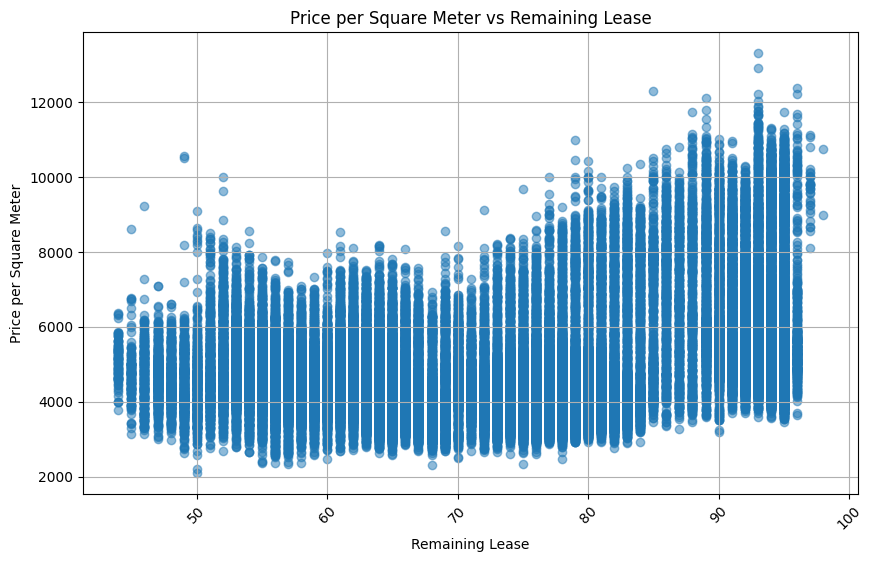

In [43]:
plt.figure(figsize=(10, 6))
plt.scatter(imputed_dataset['remaining_lease'], imputed_dataset['price_per_sqm'], alpha=0.5)
plt.title('Price per Square Meter vs Remaining Lease')
plt.xlabel('Remaining Lease')
plt.ylabel('Price per Square Meter')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True)
plt.show()
#  As can be seen from the graph higher value of the remaining lease is the price per square meter indeed tends to be higher

We also want to see the variation of resale price across different towns.

Write a script that shows the boxplot of `price_per_sqm` against varius `town`s. All towns should be listed in alphabetical order on the x-axis.

<div align="right"> (1 point) </div>

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


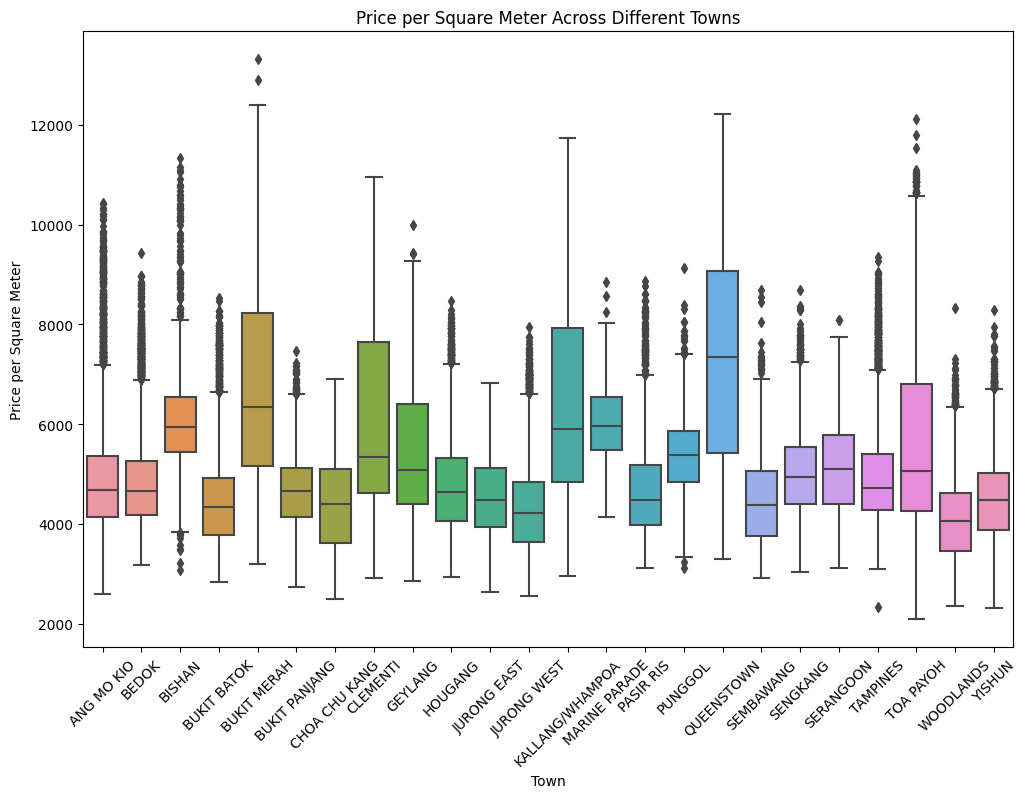

In [44]:
# Sort the dataframe by town in alphabetical order
resale_dataset_sorted = imputed_dataset.sort_values('town')

plt.figure(figsize=(12, 8))
sns.boxplot(data=resale_dataset_sorted, x='town', y='price_per_sqm')
plt.xticks(rotation=45)

plt.title('Price per Square Meter Across Different Towns')
plt.xlabel('Town')
plt.ylabel('Price per Square Meter')

plt.show()


We want to observe the number of different `flat_type` that are sold over the last four years.

Write a script that would generate a plot that looks as follows.

<div align="right"> (2 points) </div>

<img src="https://www.comp.nus.edu.sg/~ashishd/IT5006/Assignments/Assignment_1/flat_type.png" alt="flat_type" width="500"/>

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

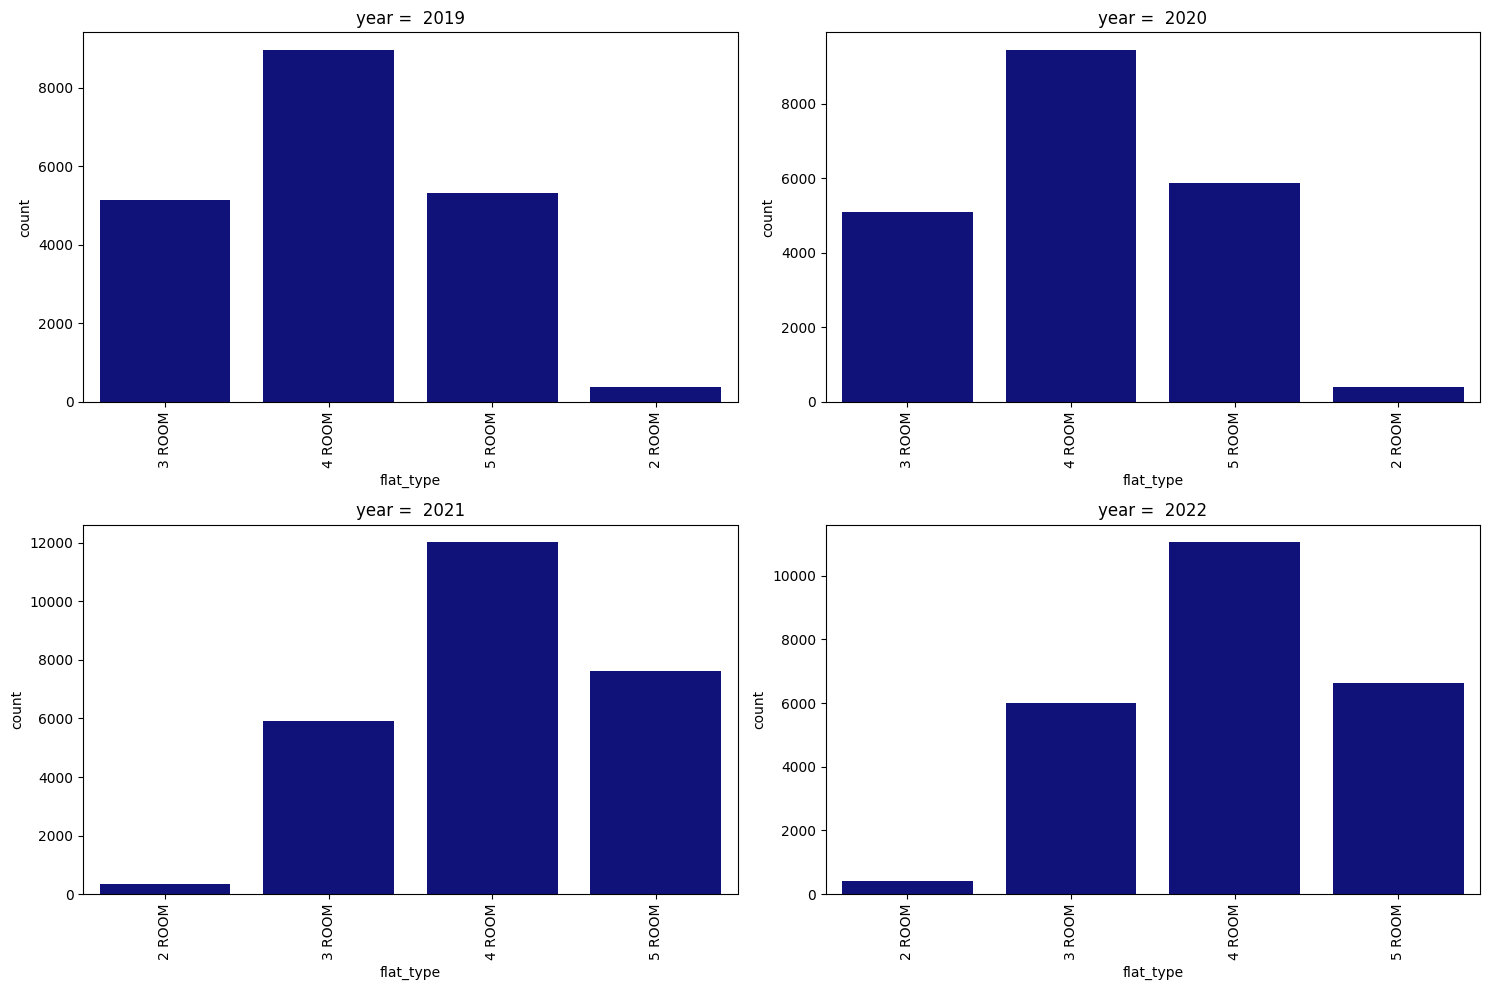

In [46]:

# Set the plot size
plt.figure(figsize=(15, 10))

# Loop through each year and create a countplot for flat_type
for i, year in enumerate(range(2019, 2023)):
    plt.subplot(2, 2, i+1)
    sns.countplot(data=imputed_dataset[imputed_dataset['year'] == year], x='flat_type', color='darkblue')
    plt.title(f'year =  {year}')
    plt.xlabel('flat_type')
    plt.ylabel('count')
    plt.xticks(rotation=90)



plt.tight_layout()
plt.show()


We want to observe the correlation between the resale price and the distance from the nearest MRT station.

Write a script that would generate a plot that looks as follows.

<div align="right"> (2 points) </div>

<img src="https://www.comp.nus.edu.sg/~ashishd/IT5006/Assignments/Assignment_1/price_mrt.png" alt="flat_type" width="800"/>

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

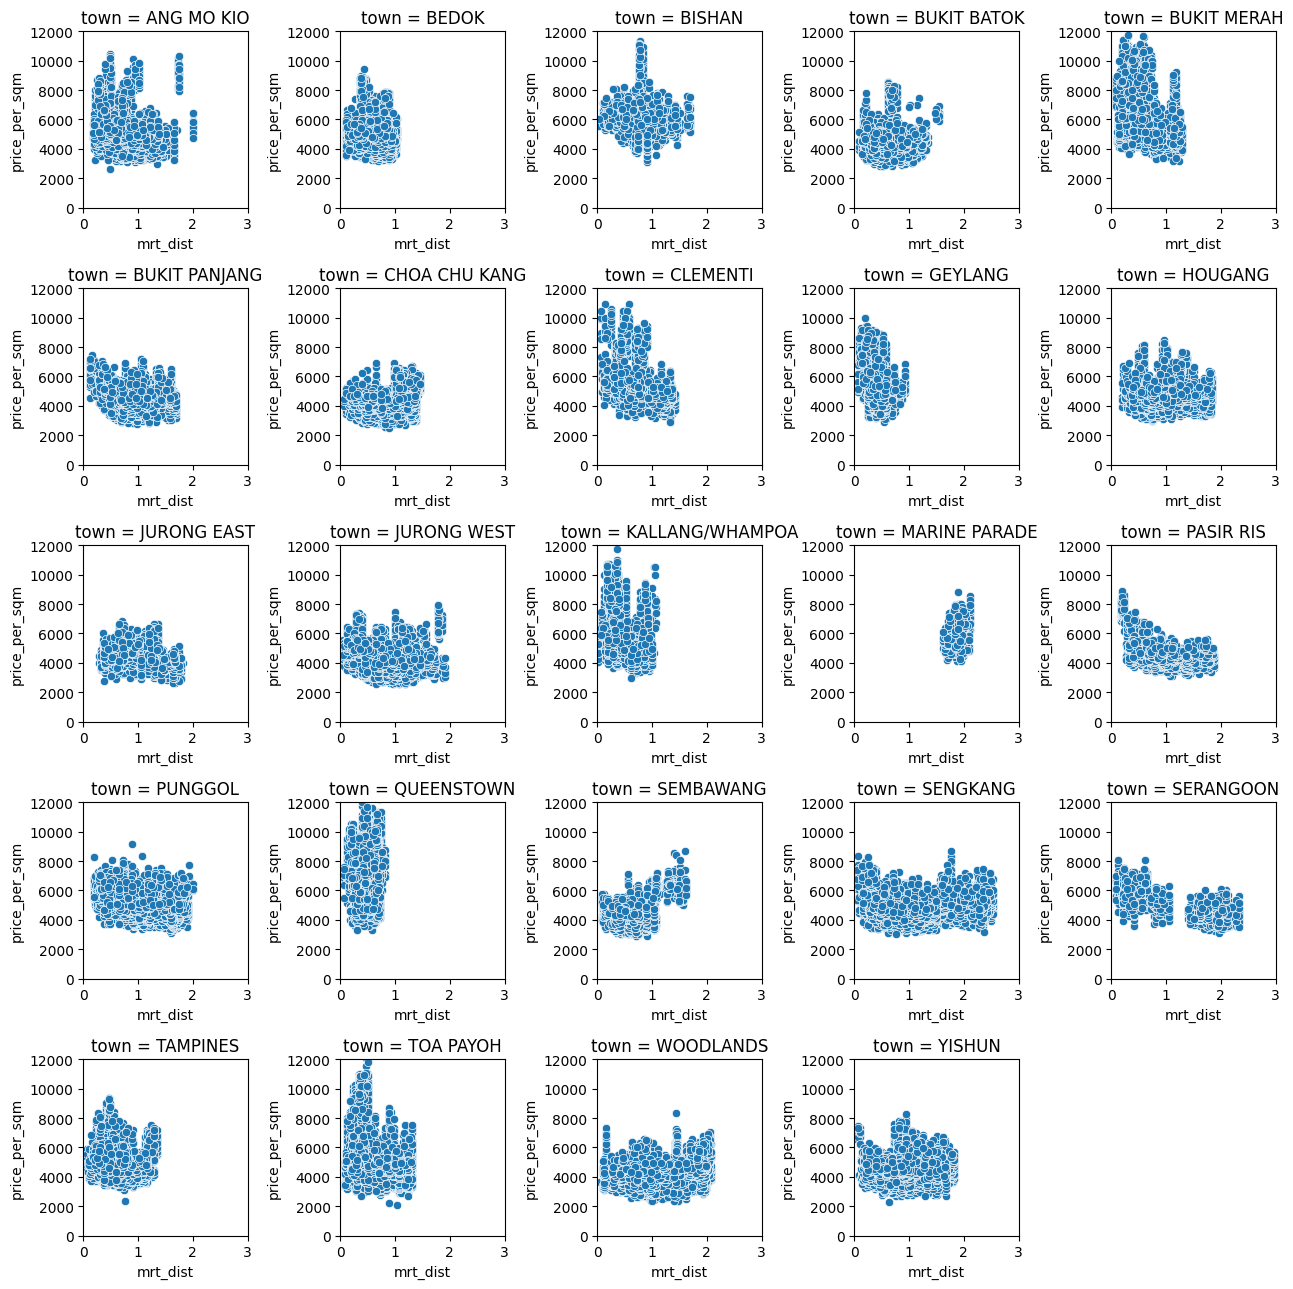

In [56]:
plt.figure(figsize=(13, 13))

for i, town in enumerate(imputed_dataset['town'].unique(), start=1):
    plt.subplot(5, 5, i)
    town_data = imputed_dataset[imputed_dataset['town'] == town]
    sns.scatterplot(data=town_data, x='mrt_dist', y='price_per_sqm')
    plt.title(f'town = {town}')
    plt.ylabel('price_per_sqm')
    plt.xlim(0, 3)
    plt.ylim(0, 12000)
    plt.tight_layout()

plt.show()


## Question 5: Analysis

Which town shows the highest variability in the `price_per_sqm` in the last four years?

<div align="right"> (1 point) </div>

*QueensTown shows the highest variability as it has the largest interquartile range*

Which observation do you make looking at the resale records as per the `flat_type` over the years? What is a probable reason for the pattern that you observe?

<div align="right">(2 points)</div>

*Right your answer here.*

- *Percentage of different types of house sold didn't vary much but these is increase in the total number of houses sold in 2021*
- *This could be a result from covid-19 and people need cash flow to support their business or needs therefore more of them start to sell their houses*

We can observe that for many towns (such as Clementi, Bukit Merah, Pasir Ris, etc.) the `price_per_sqm` has a -ve correlation to the `mrt_dist`. This fits our hypothesis.

But some towns tend to show counter-intuitive behaviour. Please provide possible reasons behind these observation. You may support your answers by further analysing the available data.

- We observe a strong positive correlation for Sembawang (which means the houses closer to MRT are cheaper than the ones that are farther!). What is a probable reason?

- We observe two distinct clusters in the plot of Sengkang and Serangoon. What is a probable reason?
<div align="right">(2 points)</div>

*Right your answer here.*

- *
Property Types: The composition of properties in Sembawang might differ significantly from other towns. For example, if there are more high-end or luxury properties located closer to the MRT station, they could skew the correlation positively.
- *Socioeconomic Factors: Sengkang and Serangoon might have diverse socioeconomic demographics, leading to distinct preferences and property values. For instance, one cluster could represent areas with higher-income residents who prioritize convenience and are willing to pay more for properties closer to MRT stations. The other cluster might consist of neighborhoods with different demographic profiles and preferences..* or Obs 2.*